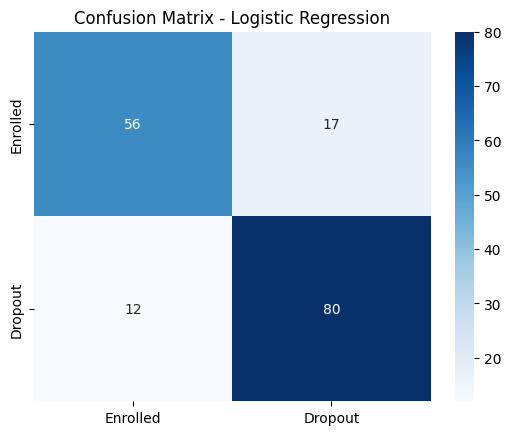

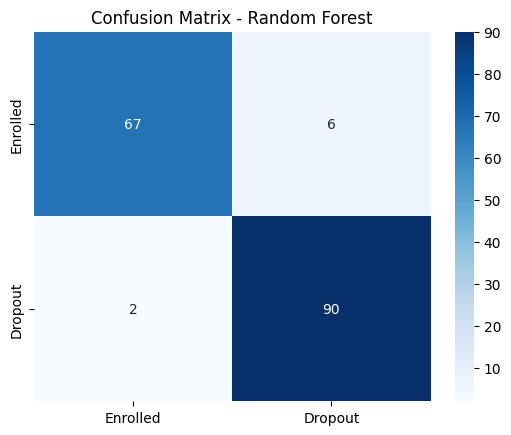

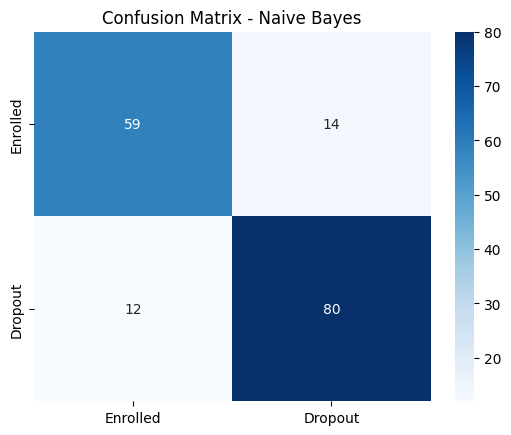

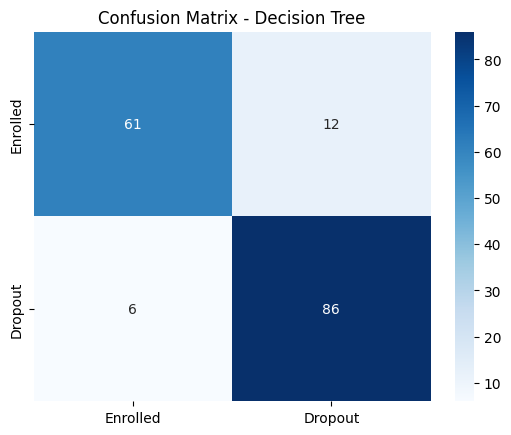

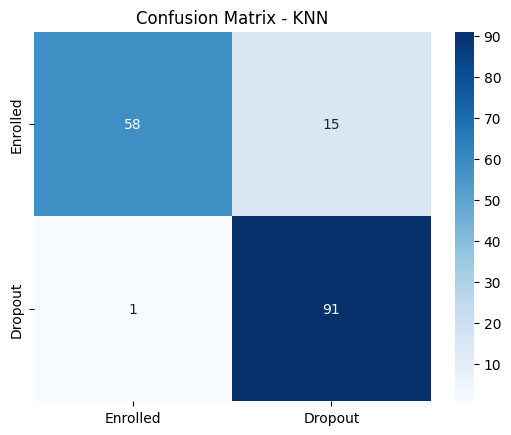

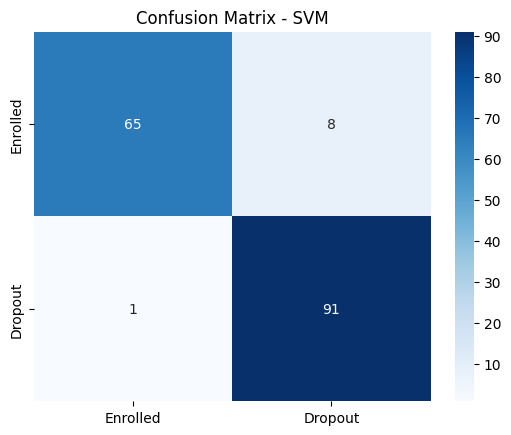

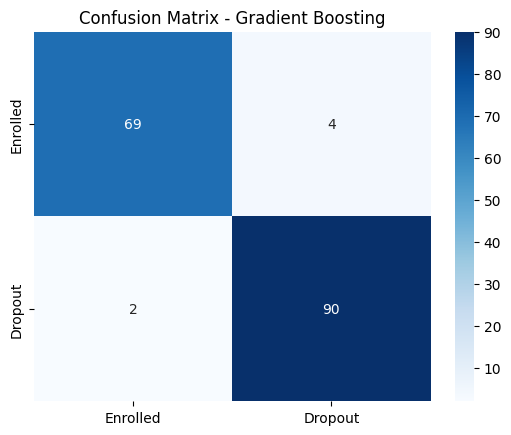

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:00:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


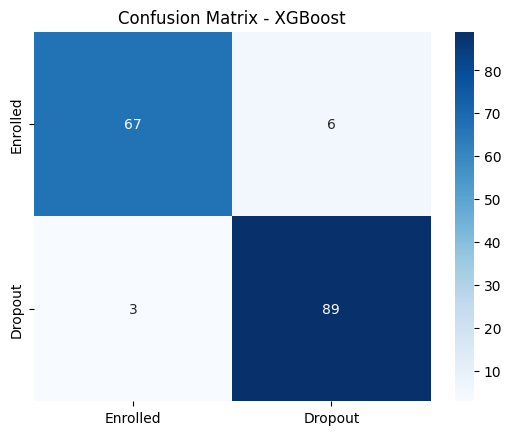

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [02:00:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


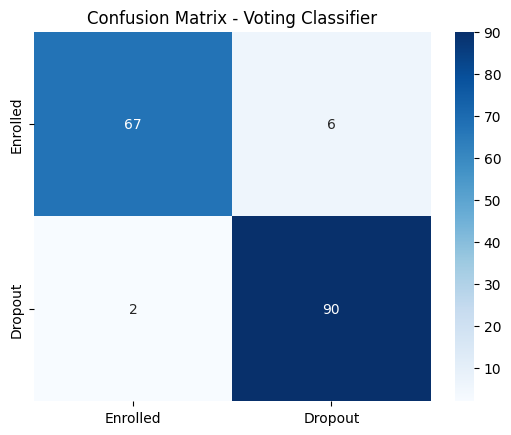

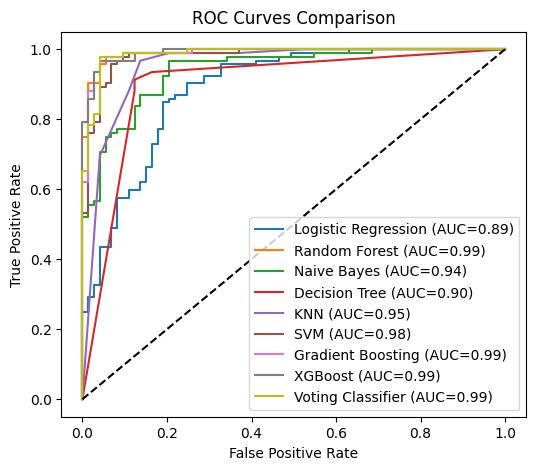

                 Model  Accuracy  Precision    Recall        F1   ROC-AUC
0  Logistic Regression  0.824242   0.824742  0.869565  0.846561  0.886837
1        Random Forest  0.951515   0.937500  0.978261  0.957447  0.990768
2          Naive Bayes  0.842424   0.851064  0.869565  0.860215  0.940441
3        Decision Tree  0.890909   0.877551  0.934783  0.905263  0.900610
4                  KNN  0.903030   0.858491  0.989130  0.919192  0.952501
5                  SVM  0.945455   0.919192  0.989130  0.952880  0.980494
6    Gradient Boosting  0.963636   0.957447  0.978261  0.967742  0.989130
7              XGBoost  0.945455   0.936842  0.967391  0.951872  0.990917
8    Voting Classifier  0.951515   0.937500  0.978261  0.957447  0.986897


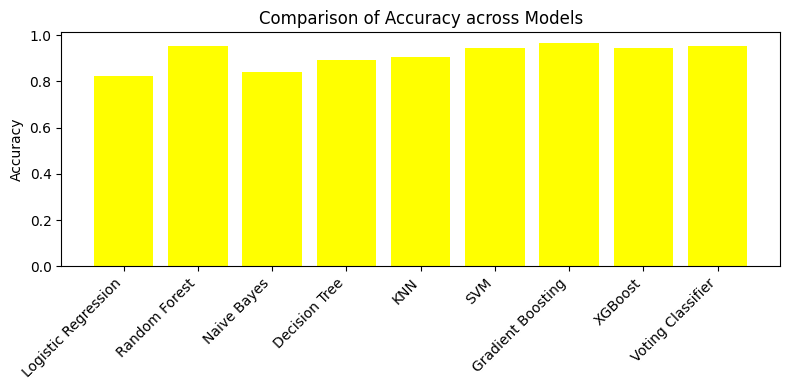

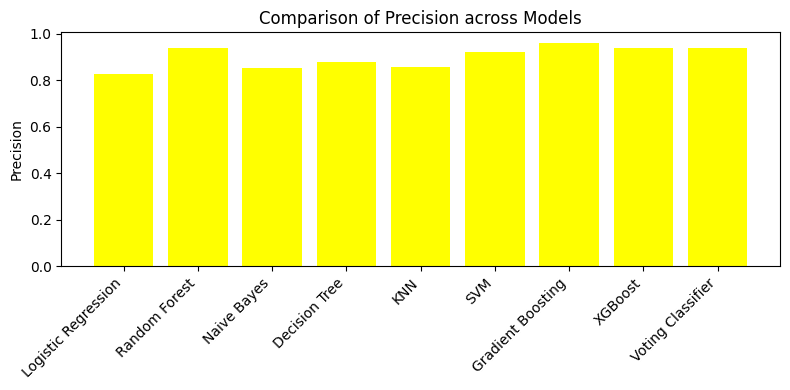

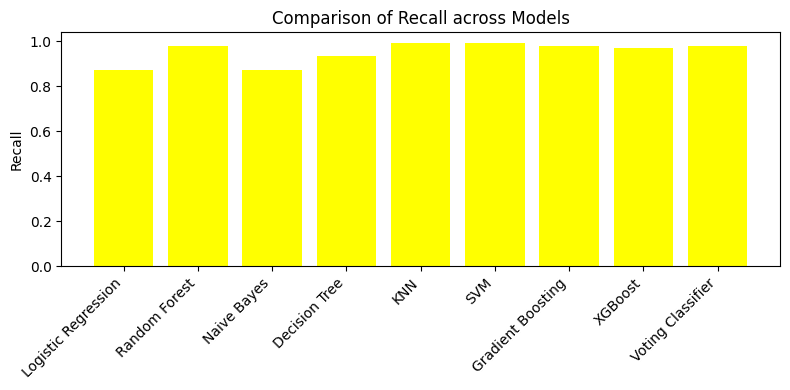

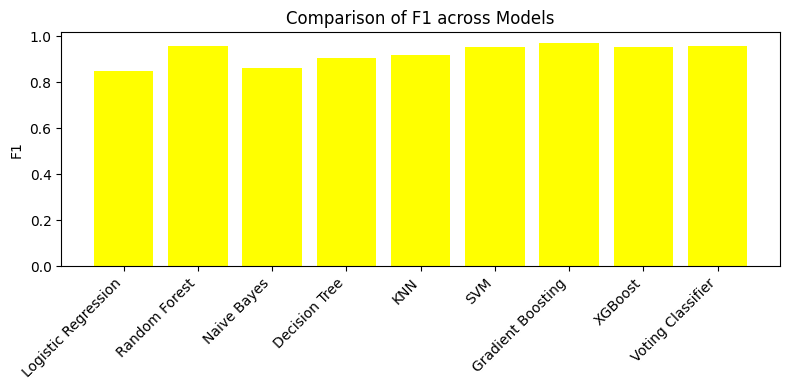

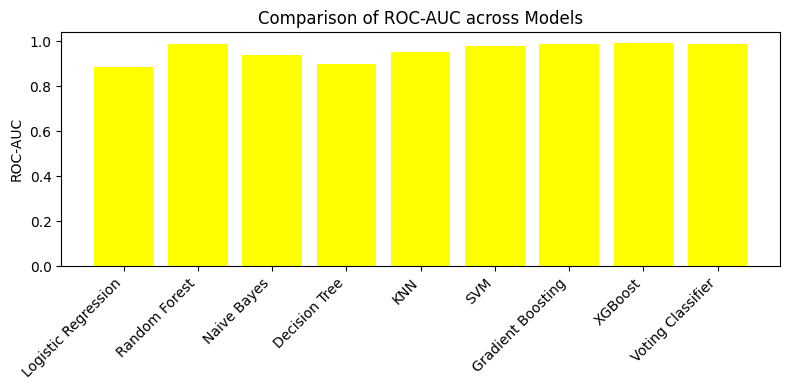

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# -----------------------------
# Load & preprocess dataset
# -----------------------------
df = pd.read_csv("SIH-Dataset.csv")
df = df.drop_duplicates()

# Fill missing numeric values with median
for col in df.columns:
    if df[col].dtype != "object":
        df[col] = df[col].fillna(df[col].median())

# Encode target
df["Dropout_Status"] = df["Dropout_Status"].map({"Dropout": 1, "Enrolled": 0})

# Drop irrelevant columns if present
for col in ["Teaching_Staff", "Dropout_Reason"]:
    if col in df.columns:
        df = df.drop(col, axis=1)

# Label encode categorical features
le = LabelEncoder()
cat_cols = df.select_dtypes(include="object").columns
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

# Features & target
X = df.drop("Dropout_Status", axis=1)
y = df["Dropout_Status"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# -----------------------------
# Define models
# -----------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=10,
                                            random_state=42, class_weight="balanced"),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(max_depth=8, random_state=42, class_weight="balanced"),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "SVM": SVC(probability=True, kernel="rbf", class_weight="balanced"),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(n_estimators=300, learning_rate=0.1, max_depth=5,
                             subsample=0.8, colsample_bytree=0.8,
                             random_state=42, use_label_encoder=False,
                             eval_metric="logloss")
}

# Voting Classifier (ensemble of top models)
voting_clf = VotingClassifier(
    estimators=[
        ("logreg", models["Logistic Regression"]),
        ("rf", models["Random Forest"]),
        ("gb", models["Gradient Boosting"]),
        ("svm", models["SVM"]),
        ("xgb", models["XGBoost"])
    ],
    voting="soft"
)
models["Voting Classifier"] = voting_clf

# -----------------------------
# Train & evaluate
# -----------------------------
results = []
roc_curves = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=1)
    rec = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    roc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan

    results.append([name, acc, prec, rec, f1, roc])

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Enrolled", "Dropout"],
                yticklabels=["Enrolled", "Dropout"])
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # ROC Curve
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_curves.append((name, fpr, tpr, roc))

# -----------------------------
# ROC curves comparison
# -----------------------------
plt.figure(figsize=(6,5))
for (name, fpr, tpr, roc) in roc_curves:
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc:.2f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves Comparison")
plt.legend()
plt.show()

# -----------------------------
# Results table
# -----------------------------
results_df = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1","ROC-AUC"])
print(results_df)

metrics = ["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]

for metric in metrics:
    plt.figure(figsize=(8,4))
    plt.bar(results_df["Model"], results_df[metric], color="yellow")
    plt.xticks(rotation=45, ha="right")
    plt.ylabel(metric)
    plt.title(f"Comparison of {metric} across Models")
    plt.tight_layout()
    plt.show()